<a href="https://colab.research.google.com/github/askmuhsin/nn_image_number/blob/main/EVA_Session_3__Group_3_assingment_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torchsummary

In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchsummary import summary

from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import random

In [3]:
## utils
def batch_imshow(batch_images):
     img = torchvision.utils.make_grid(batch_images)
     img = img / 2 + 0.5
     npimg = img.numpy()
     plt.imshow(np.transpose(npimg, (1, 2, 0)))
     plt.show()

In [4]:
class ImgPlusNum(Dataset):
  """
  This is the Main dataloader.
  It loads/downloads the minst Dataset. 
  It gets 1 image from MNIST, and 1 Random number bw 0 and 10 as one hot encoded tensor;
  then sums the LABEL of the image with the random number to produce the target label
  
  it is suited for an architecture like :
  input: <image (-1, 1, 28, 28)>. -------+------- output: <num (-1, 19)
  input: <num (-1, 10)> -----------------/
  """
  def __init__(self, train=True):
    self.train = train
    self.mnist_data_set = datasets.MNIST(
        root='./datasets/mnist_data/',
        train=self.train,
        download=True,
        transform=transforms.Compose([
          transforms.ToTensor(),
          transforms.Normalize((0.1307,), (0.3081,)),
        ])
    )
    print(self)
    
  def __len__(self):
    return len(self.mnist_data_set)

  def __getitem__(self, idx):
    img_label = self.mnist_data_set[idx][1]
    img_data = self.mnist_data_set[idx][0]

    num_data_ = torch.randint(0, 10, (1,))
    out_label_ = img_label + num_data_
    # print("** out_label_ : ", out_label_, "\n** num_data_ : ", num_data_)

    num_data = self.one_hot_encode(num_data_, 10)
    # out_label = self.one_hot_encode(out_label_, 19)
    out_label = out_label_
    return img_data, img_label, num_data, out_label
  
  def one_hot_encode(self, val, vec_len):
    num_label = torch.zeros(1, vec_len)
    num_label[0, val] = 1
    return num_label
  
  def __repr__(self):
    return 'Loaded MNIST {} data of len {}'.format(
        'training' if self.train else 'testing', self.__len__()
    )

In [5]:
use_cuda = torch.cuda.is_available()  ## on which hardware the model should be trained on
device = torch.device("cuda" if use_cuda else "cpu")  ## on which hardware the model should be trained on
device

device(type='cuda')

In [6]:
class Net(nn.Module): ## this is the standard way of creating
    def __init__(self): ## the fn gets called at the time of class creation
        super(Net, self).__init__() ## provide access of parent class methods nn.Module.__init__(self, 'Net')
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)     #input 28X28X1    | Output  28X28X32    | RF 3X3
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)    #input 28X28X32   | Output  28X28X64    | RF 5X5
        self.pool1 = nn.MaxPool2d(2, 2)                 #input 28X28X64   | Output  14X14X64    | RF 7X7
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)   #input 14X14X64   | Output  14X14X128   | RF 14X14
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)  #input 14X14X128  | Output  14X14X256   | RF 16X16
        self.pool2 = nn.MaxPool2d(2, 2)                 #input 14X14X256  | Output  7X7X256     | RF 18X18
        self.conv5 = nn.Conv2d(256, 512, 3)             #input 7X7X256    | Output  5X5X512     | RF 36X36
        self.conv6 = nn.Conv2d(512, 1024, 3)            #input 5X5X512    | Output  3X3X1024    | RF 40X40
        self.conv7 = nn.Conv2d(1024, 10, 3)             #input 3X3X1024   | Output  1X1X10      | RF 42X42
        
        self.fc1 = nn.Linear(20, 50)
        self.fc2 = nn.Linear(50, 100)
        # self.fc3 = nn.Linear(50, 50)
        # self.fc4 = nn.Linear(50, 50)
        self.fc5 = nn.Linear(100, 50)
        self.fc6 = nn.Linear(50, 19)

    def forward(self, x1, x2):
        x1 = self.pool1(F.relu(self.conv2(F.relu(self.conv1(x1))))) ## 1 layer of operation
        x1 = self.pool2(F.relu(self.conv4(F.relu(self.conv3(x1))))) ## 2nd layer of ops
        x1 = F.relu(self.conv6(F.relu(self.conv5(x1)))) ## 4th layer of operation
        x1 = self.conv7(x1)   ## final layer of conv operation
        x1 = x1.view(-1, 10)  ## changing the shape of the array
        
        x3 = torch.cat([x1, x2.view(-1, 10)], dim=1) ## this layer combines out of CNN with the random number
        x3 = F.relu(self.fc1(x3)) ## fully connected layer to learn summing
        x3 = F.relu(self.fc2(x3)) ## fully connected layer to learn summing
        # x3 = F.relu(self.fc3(x3)) ## fully connected layer to learn summing
        # x3 = F.relu(self.fc4(x3)) ## fully connected layer to learn summing
        x3 = F.relu(self.fc5(x3)) ## fully connected layer to learn summing
        x3 = self.fc6(x3)
        x3 = x3.view(-1, 19)
        out = F.log_softmax(x3, dim=0) ## returning the softmax instead of activation values, for training.
        return out

model = Net().to(device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loaded MNIST testing data of len 10000
img_data :  torch.Size([1, 1, 28, 28])
img_label :  tensor([7])
num_data : 
	value - tensor([[1]])
	shape - torch.Size([1, 1, 10])
	tensor - tensor([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]]])
out_label : 
	value - 8
	shape - torch.Size([1, 1])
	tensor - tensor([[8]])


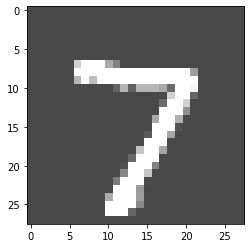

In [7]:
## debug Data Generator
dataset = ImgPlusNum(train=False)
loader = DataLoader(dataset=dataset, batch_size=1, shuffle=False)

for batch_num, (img_data, img_label, num_data, out_label) in enumerate(loader):
  print('img_data : ', img_data.shape)
  print('img_label : ', img_label)
  print('num_data : \n\tvalue - {}\n\tshape - {}\n\ttensor - {}'.format(
      num_data.argmax(dim=-1), num_data.shape, num_data)
  )
  print('out_label : \n\tvalue - {}\n\tshape - {}\n\ttensor - {}'.format(
      out_label.item(), out_label.shape, out_label)
  )
  batch_imshow(img_data)
  break

In [8]:
## debug Model
summary(model, input_size=[(1, 28, 28), (1, 1, 10)])  ## view model summary

print('\n\n')
print("input 1 (image) : ", img_data.shape)
print("input 2 (random number) : ", num_data.shape)

out = model(img_data.to(device), num_data.to(device))
print("output (sum of image and random number) : ", out.shape)
print(out, out.argmax())

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
            Conv2d-2           [-1, 64, 28, 28]          18,496
         MaxPool2d-3           [-1, 64, 14, 14]               0
            Conv2d-4          [-1, 128, 14, 14]          73,856
            Conv2d-5          [-1, 256, 14, 14]         295,168
         MaxPool2d-6            [-1, 256, 7, 7]               0
            Conv2d-7            [-1, 512, 5, 5]       1,180,160
            Conv2d-8           [-1, 1024, 3, 3]       4,719,616
            Conv2d-9             [-1, 10, 1, 1]          92,170
           Linear-10                   [-1, 50]           1,050
           Linear-11                  [-1, 100]           5,100
           Linear-12                   [-1, 50]           5,050
           Linear-13                   [-1, 19]             969
Total params: 6,391,955
Trainable param

In [9]:
torch.manual_seed(1)  ## fixed start point
batch_size = 128  ## number of images in a batch

In [10]:
## test loop
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
      for batch_num, (img_data, img_label, num_data, out_label) in tqdm(enumerate(test_loader)):
        img_data, num_data, out_label, img_label = (
          img_data.to(device), 
          num_data.to(device), 
          out_label.to(device),
          img_label.to(device),
        )
        output = model(img_data, num_data)
        test_loss += F.nll_loss(output, img_label, reduction='sum').item()  # sum up batch loss
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(img_label.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
      test_loss, correct, len(test_loader.dataset),
      100. * correct / len(test_loader.dataset))
    )

In [11]:
test_dataset = ImgPlusNum(train=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

Loaded MNIST testing data of len 10000


In [12]:
## debug test loop before training
test(model, device, test_loader)



Test set: Average loss: 4.8487, Accuracy: 232/10000 (2%)



In [13]:
def train(model, device, train_loader, optimizer): ## train fn
    model.train() ## set model to training, params will be updated
    pbar = tqdm(train_loader) ## progress
    for batch_idx, (img_data, _, num_data, out_label) in tqdm(enumerate(train_loader)):
        img_data, num_data, out_label = (
            img_data.to(device), 
            num_data.to(device), 
            out_label.squeeze().to(device),
        )
        optimizer.zero_grad() ## clean the gradients
        output = model(img_data, num_data)  ## do 1 pass of data through the network
        loss = F.nll_loss(output, out_label) ## calculate loss, bw what is predicted vs what is expected
        loss.backward() ## take the loss and compute gradient for all parameters
        optimizer.step()  ## update parameters
        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')  ## visualize progress

In [14]:
train_dataset = ImgPlusNum(train=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

Loaded MNIST training data of len 60000


In [15]:
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
optimizer = optim.Adam(model.parameters())

In [16]:
train(model, device, train_loader, optimizer)

In [18]:
test(model, device, test_loader)



Test set: Average loss: 16.9215, Accuracy: 1096/10000 (11%)



In [19]:
for epoch in range(5):
  train(model, device, train_loader, optimizer)
  test(model, device, test_loader)



Test set: Average loss: 25.2504, Accuracy: 1006/10000 (10%)





Test set: Average loss: 27.1468, Accuracy: 990/10000 (10%)





Test set: Average loss: 25.8655, Accuracy: 1083/10000 (11%)





Test set: Average loss: 25.2526, Accuracy: 979/10000 (10%)





Test set: Average loss: 24.3076, Accuracy: 978/10000 (10%)

